## Project Overview: Lecture Transcription and Question Generation

### Project Idea:

The primary goal of this project is to develop a system that can automatically convert lecture audio recordings into text and generate relevant questions based on the transcribed content. This project aims to enhance learning experiences by providing students with detailed lecture notes and facilitating active learning through generated questions.


### Benefits:

- **Enhanced Learning**: Provides students with accurate and detailed lecture transcriptions, enabling them to review and study the material effectively.
- **Active Engagement**: The generated questions encourage active learning and self-assessment, helping students to better understand and retain the lecture content.
- **Time Efficiency**: Automates the transcription and question generation process, saving time for both educators and students.




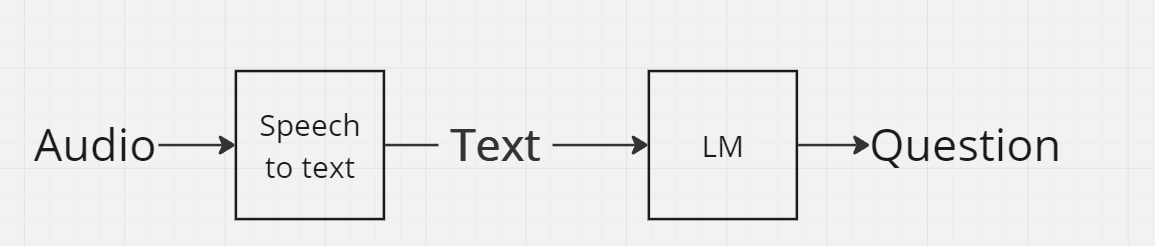

In [ ]:
!pip install git+https://github.com/openai/whisper.git
!sudo apt update && sudo apt install ffmpeg
!pip install nltk
!pip install -q -U google-generativeai
!pip install pydub
!pip install ffmpeg-python
!pip install datasets
!pip install torch==2.3.1
!pip install transformers==4.30.2
!pip install accelerate==0.20.3

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-lfd8gbkz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-lfd8gbkz
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-m

In [ ]:
import whisper
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from google.colab import drive
from pydub import AudioSegment
import numpy as np
import pathlib
import textwrap
import google.generativeai as genai
from IPython.display import display
from IPython.display import Markdown
from google.colab import userdata
import os
from datasets import load_dataset,Dataset
import pandas as pd
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Trainer, TrainingArguments
import shutil

## Load whisper model

In [ ]:
model = whisper.load_model("large")

100%|█████████████████████████████████████| 2.88G/2.88G [00:33<00:00, 91.6MiB/s]


### To test the whisper model we've gave it a video with 10 minutes long, to make an accuracy of how it works on Arabic voice and its translation to English

In [ ]:
result = model.transcribe("/content/Very Important - Nested if example.mp3",language="english")

In [ ]:
result["text"]

" Hello. In this recording, I would like to re-explain an example about the Nested-F statement. I explained it in the lecture, in the Wednesday lecture and in the Thursday lecture. On Thursday, there is no need to watch the lecture because there is no new information. On Wednesday, I think there are things that we did not explain in the lecture, we will explain them now. So, please watch the recording, it will not be more than 10 minutes. Now, the example is simply about the Nested-F statement. We have here variables, x and y, then we asked if this F is true, and based on it, a condition will be implemented. Now, the information I want to make sure of is that this F statement is not based on brackets, right? I mean, we did not start with brackets and we did not finish with brackets. It is based on one sentence. So, what is this sentence? Is this sentence just this one? Or is this sentence all this one? In fact, it is based on this condition, it is based on all this sentence. Because th

In [ ]:
result = model.transcribe("/content/Very Important - Nested if example.mp3",language="arabic")

In [ ]:
result["text"]

' مرحبا بهذا التسجيل بس بدي أعيد شرح مثال عن النستد إف ستيتمنت شرحته بالمحاضرة بمحاضرة الأربعة ومحاضرة الخميس طلاب يوم الخميس ما في داعي تحضروا الشرح لأنه ما فيش ولا معلومة جديدة طلاب يوم الأربعة أعتقد فيه أشياء ما حكيناها بالمحاضرة رح نحكيها هلأ فلو سمحتوا احضروا التسجيل مش رح يكون أكتر من عشر دقايق هلأ المثال ببساطة هو كان عن النستد إف ستيتمنت عرفنا هنا متغيرات X و Y بعدين سألنا إذا هاي الإف ترو وبناء عليها بدأ يتنفذ عليها شرط هلأ المعلومة اللي بدي أكد عليها أنه هاي الإف ستيتمنت مبني عليها ما في أقواس صح يعني ما بلشنا بأقواس وما نهينا بأقواس مبني عليها جملة واحدة طب هاي الجملة شو هي؟ هل هاي الجملة بس هاي؟ ولا هاي الجملة كل هاي؟ في الحقيقة هو المبني على هاي هذا ال condition مبني عليه كل هاي الجملة لأنه ال else دايما بتتبع ال f اللي قبلها فبالتالي هاي ال f و هاي ال else هما block وحدة فإذا كان هذا الشرط true معناته كل هذا كل هذا رح يتنفذ بينما إذا كان false ما عندي else يعني هاي ال f ما إلها else بينما هاي ال else تابعة على ال f اللي هي نستد اللي هي داخلة جوا الأوتر condition هذا هاي ا

We've made a comparison between the whisper's translation and the translation of the Arabic text using other tool.

For the comparison we used BLEU score

In [ ]:
nltk.download('punkt')

whisper_english_text = "Hello. In this recording, I would like to re-explain an example about the Nested-F statement. I explained it in the lecture, in the Wednesday lecture and in the Thursday lecture. On Thursday, there is no need to watch the lecture because there is no new information. On Wednesday, I think there are things that we did not explain in the lecture, we will explain them now. So, please watch the recording"
whisper_arabic_text = "Hello. In this recording, I would like to re-explain an example about the nested if statement. I explained it in the Wednesday lecture and in the Thursday lecture. Thursday students, there is no need to watch because there is no new information. Wednesday students, I think there are things we didn't explain in the lecture that we will explain now. So, please watch the recording."

english = [word_tokenize(whisper_english_text.lower())]
arabic = word_tokenize(whisper_arabic_text.lower())

smooth = SmoothingFunction().method1
score = sentence_bleu(english, arabic, smoothing_function=smooth)

print(f"BLEU score: {score}")


BLEU score: 0.6616948665805465


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Connect to Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Fetch the Audio files from Google Drive to pass it to Whisper, and store the text files in Google Drive.

In [ ]:
folder_path = '/content/drive/My Drive/Colab Notebooks/MP3'
output_folder_path = '/content/drive/My Drive/Colab Notebooks/text'

files = os.listdir(folder_path)

for mp3_file in files:
    mp3_file_path = os.path.join(folder_path, mp3_file)

    audio = AudioSegment.from_mp3(mp3_file_path)

    temp_wav_path = "/tmp/temp_audio.wav"
    audio.export(temp_wav_path, format="wav")


    result = model.transcribe(temp_wav_path, language="english")
    text = result["text"]

    text_file_path = os.path.join(output_folder_path, f"{os.path.splitext(mp3_file)[0]}.txt")
    with open(text_file_path, "w") as text_file:
        text_file.write(text)

    print(f"text saved for {mp3_file} at {text_file_path}")


text saved for 1.mp3 at /content/drive/My Drive/Colab Notebooks/text/1.txt
text saved for 2.mp3 at /content/drive/My Drive/Colab Notebooks/text/2.txt
text saved for 4.mp3 at /content/drive/My Drive/Colab Notebooks/text/4.txt
text saved for 5.mp3 at /content/drive/My Drive/Colab Notebooks/text/5.txt
text saved for 3.mp3 at /content/drive/My Drive/Colab Notebooks/text/3.txt
text saved for 6.mp3 at /content/drive/My Drive/Colab Notebooks/text/6.txt


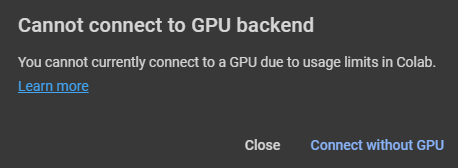

Use Gemini configuration

In [ ]:
GOOGLE_API_KEY="*"

genai.configure(api_key=GOOGLE_API_KEY)

Load Gimini model

In [ ]:
model = genai.GenerativeModel('gemini-pro')

To print the text from Gemini in a better way

In [ ]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

Fetch the text files from Google Drive

In [ ]:
folder_path = '/content/drive/My Drive/Colab Notebooks/text'

files = os.listdir(folder_path)
content=[]
for file_name in files:
      file_path = os.path.join(folder_path, file_name)
      with open(file_path, 'r') as file:
          content.append(file.read())


In [ ]:
print(len(content[5]))

57880


Since the Gimini Model accepts a specific max number of characters, we've splitted the text files into chunks

In [ ]:
def split_text(text, max_length):
    chunks = [text[i:i + max_length] for i in range(0, len(text), max_length)]
    return chunks

In [ ]:
x=split_text(content[0],2000)

In [ ]:
print(len(x))

30


In [ ]:
response = model.generate_content(f"summarize this text about the software development, then generate 7 essay question about the software and give me the answer{x[0]}")
to_markdown(response.text)

> **Summary of the Text**
> 
> The text discusses the challenges and recommendations for distributed Scrum, a software development approach where team members are dispersed across different locations. The recommendations include:
> 
> * Having the Scrum Master located with the development team for better communication and problem awareness.
> * Using video conferencing for more efficient communication between team members and the product owner.
> * Providing a common development environment for all team members to facilitate collaboration.
> * Implementing continuous integration to track the status of the product at all times.
> * Establishing real-time communication through instant messaging and video calls.
> * Encouraging the product owner to visit the developers and build strong relationships.
> * Organizing team gatherings to foster face-to-face interactions and strengthen bonds.
> 
> **Essay Questions**
> 
> 1. Define distributed Scrum and explain its challenges.
> 2. Describe the recommendation to have the Scrum Master located with the development team.
> 3. Explain the importance of video conferencing in distributed Scrum.
> 4. Discuss the benefits of implementing a common development environment.
> 5. Explain how continuous integration contributes to the success of distributed Scrum.
> 6. Describe the recommendation for real-time communication in distributed Scrum.
> 7. Explain the role of the product owner in distributed Scrum and how they can build strong relationships with the team.
> 
> **Answers**
> 
> 1. **Define distributed Scrum and explain its challenges.**
>    - Distributed Scrum is a software development approach where team members are dispersed across different locations.
>    - Challenges include: lack of face-to-face communication, coordination difficulties due to distance, and time zone differences.
> 
> 2. **Describe the recommendation to have the Scrum Master located with the development team.**
>    - This recommendation aims to improve communication, enhance problem awareness, and facilitate collaboration. By being physically present with the team, the Scrum Master can observe daily activities and provide immediate support.
> 
> 3. **Explain the importance of video conferencing in distributed Scrum.**
>    - Video conferencing enables more efficient communication between team members. It allows for visual cues, better understanding of body language, and a more engaging and immersive experience.
> 
> 4. **Discuss the benefits of implementing a common development environment.**
>    - A common development environment ensures that all team members use the same tools, software, and configurations. This streamlines collaboration, reduces errors, and facilitates knowledge sharing.
> 
> 5. **Explain how continuous integration contributes to the success of distributed Scrum.**
>    - Continuous integration automates the process of building, testing, and integrating code changes. It provides real-time feedback on the status of the product, helping team members identify and resolve issues promptly.
> 
> 6. **Describe the recommendation for real-time communication in distributed Scrum.**
>    - Real-time communication is essential for distributed Scrum teams to maintain coordination and address urgent matters. Instant messaging and video calls allow for immediate communication, reducing delays and fostering a sense of teamwork.
> 
> 7. **Explain the role of the product owner in distributed Scrum and how they can build strong relationships with the team.**
>    - The product owner is responsible for defining the product vision and prioritizing requirements. In distributed Scrum, they need to build strong relationships with the team through regular communication, visits, and the establishment of trust.

Load flan-t5 model from hugging face, and test it

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

inputs = tokenizer("Explain artificial intelligence", return_tensors="pt")
outputs = model.generate(**inputs)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Artificial intelligence is a tool used to describe the behavior of a person.']


In [ ]:
# model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")
# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

showin the configuration of the flan-t5

In [ ]:
print(model.config)

T5Config {
  "_name_or_path": "google/flan-t5-large",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2816,
  "d_kv": 64,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 16,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "transformers_version": "4.41.2",
  "use_cache": true,
  "vocab_size": 32128
}



In [ ]:
my_text="Explain artificial intelligence"

We have edited the configurations for generating text summaries using a pre-trained transformer model.

## Configuration Parameters and Their Benefits

### Configuration Parameters:

1. **`min_length=256`**:
   - Ensures that the generated summary has a minimum length of 256 tokens, providing a more detailed summary.

2. **`max_new_tokens=512`**:
   - Limits the number of new tokens generated to 512, preventing overly long summaries while providing ample space for detailed information.

3. **`length_penalty=2`**:
   - Applies a penalty to shorter sequences, encouraging the model to generate longer and more informative summaries.

4. **`num_beams=16`**:
   - Uses beam search with 16 beams, enhancing the quality of the generated text by exploring multiple possible sequences and selecting the best one.

5. **`no_repeat_ngram_size=2`**:
   - Prevents the model from repeating n-grams of size 2, reducing redundancy and improving the coherence of the summary.

6. **`early_stopping=True`**:
   - Stops the beam search early when at least `num_beams` beams have been fully generated, speeding up the inference process while maintaining quality.

### Benefits of the Configurations:

- **Enhanced Quality**: The use of beam search with multiple beams and length penalty ensures higher quality and more coherent summaries.
- **Reduced Redundancy**: By preventing n-gram repetitions, the summaries are more concise and less repetitive.
- **Optimized Length**: The minimum length and maximum new tokens parameters provide a balanced summary length, avoiding overly brief or excessively long outputs.
- **Efficiency**: Early stopping speeds up the generation process, making it more efficient without compromising on the quality of the summaries.


In [ ]:
%%time

inputs=tokenizer(f"summarize the text about the software requirement:{x[0]}",return_tensors="pt")
outputs=model.generate(**inputs, \
                       min_length=256,\
                       max_new_tokens=512, \
                       length_penalty=2,\
                       num_beams=16, \
                       no_repeat_ngram_size=2,\
                       early_stopping=True)
output_text_Flan_t5=tokenizer.batch_decode(outputs,\
                                           skip_special_tokens=True)
print(output_text_Flan_t5)

["It is difficult to achieve face-to-face communication. Because the team is always distributed. For example, right now, I am working with everyone from Canada, from Ukraine, France, Egypt, Jordan, America, India, and so on. So, this talk, it makes us feel that we have, let me say, challenges. We see how we do them with what we call distributed Scrum. I have one more question. Go ahead. First of all, good morning. Doctor, We have almost finished the third chapter. But the last thing we will talk about is this slide. You can see the screen. Okay, everything is fine. Now, in terms of SCRUM in general, there is a lot of talking about always trying to have the Team present Face-To-Face. Always face to Face communication is one of the best things ever. The talk is not about the world. It focuses on the software. Distributed Team is very difficult. Even when I was working, with Exalt and Cisco, they were all distributed - from Guatemala and America to India and Argentina. They are very distr

In [ ]:
summarize_text=output_text_Flan_t5

["It is difficult to achieve face-to-face communication. Because the team is always distributed. For example, right now, I am working with everyone from Canada, from Ukraine, France, Egypt, Jordan, America, India, and so on. So, this talk, it makes us feel that we have, let me say, challenges. We see how we do them with what we call distributed Scrum. I have one more question. Go ahead. First of all, good morning. Doctor, We have almost finished the third chapter. But the last thing we will talk about is this slide. You can see the screen. Okay, everything is fine. Now, in terms of SCRUM in general, there is a lot of talking about always trying to have the Team present Face-To-Face. Always face to Face communication is one of the best things ever. The talk is not about the world. It focuses on the software. Distributed Team is very difficult. Even when I was working, with Exalt and Cisco, they were all distributed - from Guatemala and America to India and Argentina. They are very distr

Generate question from the summarized text

In [ ]:
%%time

inputs=tokenizer(f"generate  essay question about the software and give me the answers{summarize_text}",return_tensors="pt")
outputs=model.generate(**inputs, \
                       min_length=256,\
                       max_new_tokens=512, \
                       length_penalty=2,\
                       num_beams=16, \
                       no_repeat_ngram_size=2,\
                       early_stopping=True)
output_text_Flan_t5=tokenizer.batch_decode(outputs,\
                                           skip_special_tokens=True)
print(output_text_Flan_t5)

["Why is it difficult to achieve face-to-face communication? Because the team is always distributed. For example, right now, I am working with everyone from Canada, from Ukraine, France, Egypt, Jordan, America, India, and so on. So, this talk, it makes us feel that we have, let me say, challenges. We see how we do them with what we call distributed Scrum. You can see the screen. Okay, everything is fine. Now, in terms of SCRUM in general, there is a lot of talking about always trying to have the Team present Face-To-Face. Always face to Face communication is one of the best things ever. The talk is not about the world. It focuses on the software. Distributed Team is very difficult. Even when I was working, with Exalt and Cisco, they were all distributed - from Guatemala and America to India and Argentina. They are very distributed and they work with each other in different countries. That's why it is so important for us to understand the challenges we face with the distributed team and

In [ ]:
# dataset = load_dataset("kelSidenna/softwareReq-data")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5640 [00:00<?, ? examples/s]

In [ ]:
# len(dataset["train"])

5640

In [ ]:
# dataset

DatasetDict({
    train: Dataset({
        features: ['formatted_text'],
        num_rows: 5640
    })
})

Make findtuning on the flan-t5-small (we used the small version because the resources didn't meet the requirements)



In [ ]:
df = pd.read_csv('/content/software_requirements_extended.csv')

dataset = Dataset.from_pandas(df)

train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

def preprocess_function(examples):
    inputs = [ex for ex in examples['Requirement']]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    labels = [ex for ex in examples['Type']]
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(labels, max_length=128, truncation=True, padding="max_length")

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

trainer.train()

model.save_pretrained('./fine-tuned-t5')
tokenizer.save_pretrained('./fine-tuned-t5')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Map:   0%|          | 0/781 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3619: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/196 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,12.534464
2,No log,5.300004
3,No log,4.742251


('./fine-tuned-t5/tokenizer_config.json',
 './fine-tuned-t5/special_tokens_map.json',
 './fine-tuned-t5/spiece.model',
 './fine-tuned-t5/added_tokens.json',
 './fine-tuned-t5/tokenizer.json')

As we can see in the output of the previous cell, the validation loss in each epoch is going down which tell us the findtuning in its right direction

Evaluate the trainer

In [ ]:
trainer.evaluate()

{'eval_loss': 4.742250919342041,
 'eval_runtime': 170.6439,
 'eval_samples_per_second': 1.149,
 'eval_steps_per_second': 0.147,
 'epoch': 3.0}

Load the findtuened model

In [ ]:
model_path = '/content/fine-tuned-t5'
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
%%time

inputs=tokenizer(f"summarize the text about the software requirement:{x[0]}",return_tensors="pt")
outputs=model.generate(**inputs, \
                       min_length=256,\
                       max_new_tokens=512, \
                       length_penalty=2,\
                       num_beams=16, \
                       no_repeat_ngram_size=2,\
                       early_stopping=True)
output_text_Flan_t5=tokenizer.batch_decode(outputs,\
                                           skip_special_tokens=True)
print(output_text_Flan_t5)
output_text_Flan_t5

["We will not explain this thing. What is distributed Scrum? We did not talk about it before. Did you see the lecture that was recorded? No, there was no lecture. Two. Okay. So, we took the whole back-to-back planning, right? Yes, I am sure you explained it. We arrived here, but we won't explain it, what we talked about before, and that's what I remember. I have one more question. Go ahead. First of all, good morning, doctor. Well, this talk, it makes us feel that we have, let me say, challenges we must face. And so, the talk is not about the world. It is difficult to achieve this. Because the team is always distributed. Even when I was working with Exalt and Cisco, they were all distributed, from Guatemala, America, India. All of them are distributed and distributed to everyone from Canada, Ukraine, France, Egypt, Jordan and from America and so on. That is a lot of talk. But the last thing we will talk on is this slide. You can find the screen at the bottom right corner of this page. 

In [ ]:
%%time
inputs=tokenizer(f"generate  essay question about the software and give me the answers{output_text_Flan_t5}",return_tensors="pt")
outputs=model.generate(**inputs, \
                       min_length=256,\
                       max_new_tokens=512, \
                       length_penalty=2,\
                       num_beams=16, \
                       no_repeat_ngram_size=2,\
                       early_stopping=True)
output_text_Flan_t5=tokenizer.batch_decode(outputs,\
                                           skip_special_tokens=True)
print(output_text_Flan_t5)


['Distributed Scrum is a software that is distributed to everyone from Canada, Ukraine, France, Egypt, Jordan and so on. What is the last thing we will talk on is this slide that we can find the screen at the bottom right corner of this page. Which of the following statements is TRUE according to the passages in the article, i.e., "We will not explain this thing. We did not talk about it before. Did you see the lecture that was recorded? No, there was no lecture. Two. Okay. So, we took the whole back-to-back planning, right? Yes, I am sure you explained it. They arrived here, but we won\'t explain it, what we talked about before, and that\'s what I remember. I have one more question. Go ahead. First of all, good morning, doctor. Well, this talk, it makes us feel that We have, let me say, challenges we must face. And so, the talk is not about the world. It is difficult to achieve this. Because the team is always distributed. Even when I was working with Exalt and Cisco, they were all di

Save the findtuened model on Google Drive

In [ ]:
destination_dir = '/content/drive/My Drive/Colab Notebooks/fine-tuned-t5/'

shutil.copytree(model_path, destination_dir)

'/content/drive/My Drive/Colab Notebooks/fine-tuned-t5/'

Load the findtuened model from Google Drive, and test it

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/fine-tuned-t5/'


model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
%%time
inputs=tokenizer(f"generate  essay question about the software and give me the answers{x[0]}",return_tensors="pt")
outputs=model.generate(**inputs, \
                       min_length=256,\
                       max_new_tokens=512, \
                       length_penalty=2,\
                       num_beams=16, \
                       no_repeat_ngram_size=2,\
                       early_stopping=True)
output_text_Flan_t5=tokenizer.batch_decode(outputs,\
                                           skip_special_tokens=True)
print(output_text_Flan_t5)

['See where we arrived. See? We never entered this, right? No, we did not talk about it before. Did you see the lecture that was recorded? I was with you. I attended every lecture, I even counted on Excel. Yes, exactly. This is what I remember. You are the first. What is distributed Scrum? Are you sure you explained it? Do you have a question about the software? It is difficult to achieve this. So, this talk, it makes us feel that we have, let me say, challenges we must face. And so on. We have one more question. Go ahead. First of all, good morning. Doctor, We took the whole back-to-back planning, just to see how we do them with what we call distributed scrum. Which is the team that are distributed. The answer: no, they took this thing, not just the two. They were all distributed, from Guatemala, America, India. All of them were distributed by Exalt and Cisco. Can you tell me the name of the company you are working with? If so, you can ask me if you would like to speak with them. Than